In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.solvers.sde import Euler
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess
from mixedbridge.baselines.pcn import PreconditionedCrankNicolson
from mixedbridge.baselines.sm import ScoreMatchingReverseBridge, ScoreMatchingForwardBridge
from mixedbridge.networks.score_net import ScoreNetSmall

In [3]:
dim = 2
alpha = 1. / 16.
sigma = 0.1
T = 4.0
dt = 1. / 40
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
xT = jnp.array([2.0, -0.1], dtype=dtype)

n_batches = 32

In [4]:
wiener_process = WienerProcess(dim=dim, dtype=dtype, T=T, dt=dt)
cell_proc = CellDiffusionProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)
cell_aux_proc = CellDiffusionAuxProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)

Text(0.5, 1.0, 'Unconditional process')

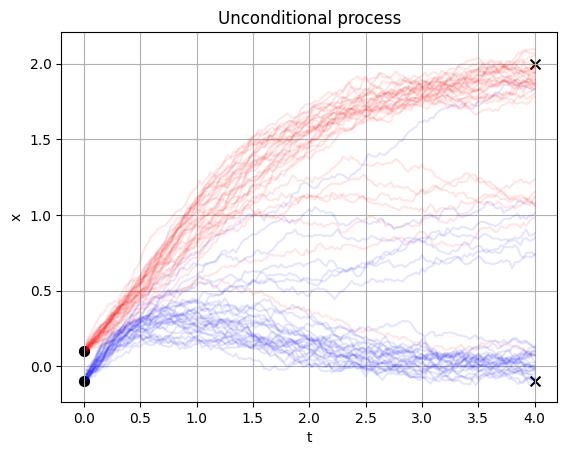

In [5]:
cell_proc_solver = Euler(cell_proc, wiener_process)
cell_path = cell_proc_solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=False, n_batches=n_batches)
for i in range(n_batches):
    plt.plot(cell_path.ts, cell_path.xs[i, :, 0], color='r', alpha=0.1)
    plt.plot(cell_path.ts, cell_path.xs[i, :, 1], color='b', alpha=0.1)
plt.scatter(0.0, x0[0], color='black', marker='o', s=50)
plt.scatter(0.0, x0[1], color='black', marker='o', s=50)
plt.scatter(T, xT[0], color='black', marker='x', s=50)
plt.scatter(T, xT[1], color='black', marker='x', s=50)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Unconditional process")

In [6]:
L0 = jnp.eye(dim, dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
cell_guided_proc = GuidedBridgeProcess(cell_proc, cell_aux_proc, L0, Sigma0, x0=x0, xT=xT)
cell_guided_proc_solver = Euler(cell_guided_proc, wiener_process)
cell_guided_path = cell_guided_proc_solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=True, n_batches=n_batches)

Text(0.5, 1.0, 'Guided process')

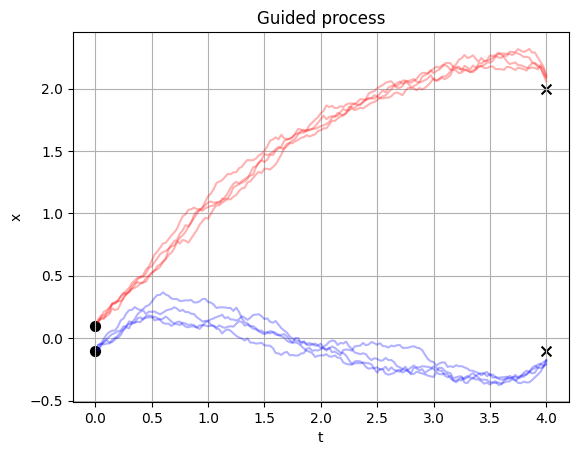

In [7]:
plt.figure()
for i in range(4):
    plt.plot(cell_guided_path.ts, cell_guided_path.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(cell_guided_path.ts, cell_guided_path.xs[i, :, 1], color='b', alpha=0.3)
plt.scatter(0.0, x0[0], color='black', marker='o', s=50)
plt.scatter(0.0, x0[1], color='black', marker='o', s=50)
plt.scatter(T, xT[0], color='black', marker='x', s=50)
plt.scatter(T, xT[1], color='black', marker='x', s=50)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Guided process")

In [8]:
mcmc_model = PreconditionedCrankNicolson(
    x0=x0,
    xT=xT,
    ori_proc=cell_proc,
    aux_proc=cell_aux_proc,
    rho=0.98,
    L0=L0,
    Sigma0=Sigma0,
    rng_key=jax.random.PRNGKey(42),
    n_batches=n_batches
)
path_mcmc, lls = mcmc_model.run(n_iters=20000, verbose=True, log_every=1000)

Iteration 1/20000: log likelihood = 163.7218475341797
Iteration 1001/20000: log likelihood = 274.79083251953125
Iteration 2001/20000: log likelihood = 277.20013427734375
Iteration 3001/20000: log likelihood = 281.4447326660156
Iteration 4001/20000: log likelihood = 286.64056396484375
Iteration 5001/20000: log likelihood = 262.7070617675781
Iteration 6001/20000: log likelihood = 256.984375
Iteration 7001/20000: log likelihood = 285.28643798828125
Iteration 8001/20000: log likelihood = 269.244140625
Iteration 9001/20000: log likelihood = 274.1185302734375
Iteration 10001/20000: log likelihood = 286.99920654296875
Iteration 11001/20000: log likelihood = 276.8934631347656
Iteration 12001/20000: log likelihood = 295.4792785644531
Iteration 13001/20000: log likelihood = 298.4985656738281
Iteration 14001/20000: log likelihood = 286.77777099609375
Iteration 15001/20000: log likelihood = 275.8326721191406
Iteration 16001/20000: log likelihood = 282.172607421875
Iteration 17001/20000: log likeli

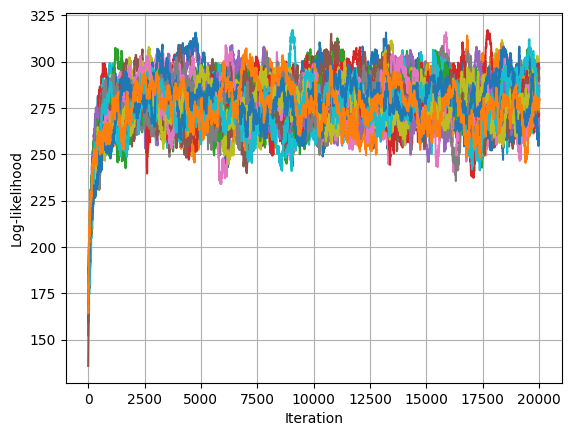

In [9]:
for i in range(n_batches):
    plt.plot(lls[:, i])
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.grid()
# plt.savefig('./cell_mcmc_lls.png', dpi=150, bbox_inches='tight')

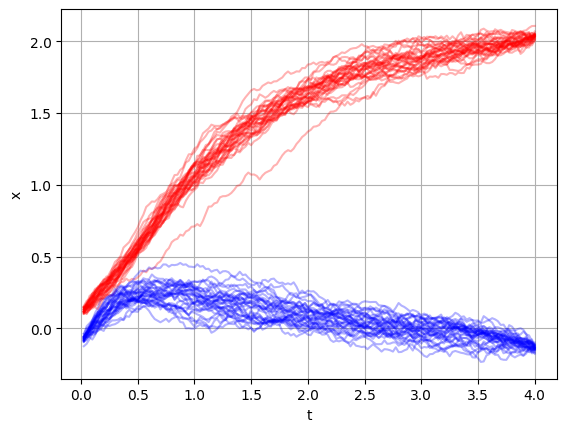

In [10]:
for i in range(n_batches):
    plt.plot(path_mcmc.ts, path_mcmc.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path_mcmc.ts, path_mcmc.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
# plt.savefig('./cell_mcmc_sample.png', dpi=150, bbox_inches='tight')

In [11]:
sm_model = ScoreMatchingReverseBridge(
    x0=x0,
    xT=xT,
    proc=cell_proc,
    model=ScoreNetSmall(out_dim=dim, hidden_dims=[20, 20, 20, 20]),
    rng_key=jax.random.PRNGKey(42),
    n_batches=32,
    lr=1e-3
)

In [15]:
sm_path, reverse_bridge = sm_model.run(n_iters=5000)

Iter 0/5000, Loss: 158.4030303955078
Iter 100/5000, Loss: 159.59173583984375
Iter 200/5000, Loss: 158.8757781982422
Iter 300/5000, Loss: 152.72242736816406
Iter 400/5000, Loss: 155.70652770996094
Iter 500/5000, Loss: 156.01600646972656
Iter 600/5000, Loss: 155.052978515625
Iter 700/5000, Loss: 157.19989013671875
Iter 800/5000, Loss: 153.7310333251953
Iter 900/5000, Loss: 156.30941772460938
Iter 1000/5000, Loss: 155.99346923828125
Iter 1100/5000, Loss: 153.5963897705078
Iter 1200/5000, Loss: 153.57412719726562
Iter 1300/5000, Loss: 157.25064086914062
Iter 1400/5000, Loss: 153.41207885742188
Iter 1500/5000, Loss: 154.060546875
Iter 1600/5000, Loss: 154.085693359375
Iter 1700/5000, Loss: 154.54507446289062
Iter 1800/5000, Loss: 153.44898986816406
Iter 1900/5000, Loss: 154.14288330078125
Iter 2000/5000, Loss: 155.18789672851562
Iter 2100/5000, Loss: 151.69456481933594
Iter 2200/5000, Loss: 153.17039489746094
Iter 2300/5000, Loss: 154.42767333984375
Iter 2400/5000, Loss: 156.3574676513672
I

In [16]:
solver = Euler(reverse_bridge, wiener_process)
path = solver.solve(xT, dWs=None, rng_key=rng_key, log_likelihood=False, n_batches=32)

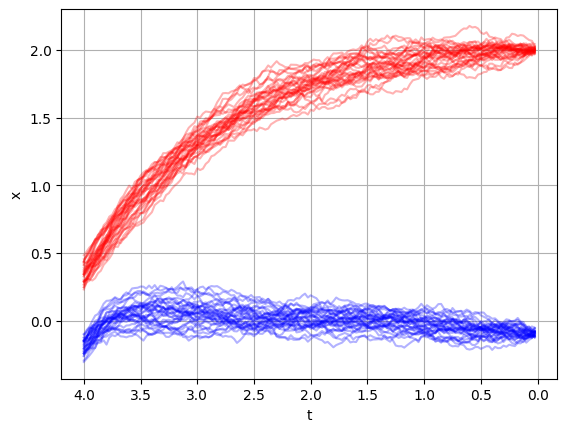

In [17]:
for i in range(32):
    # plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    # plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
# 获取当前y轴的范围
x_min, x_max = plt.xlim()

# 反转y轴范围，实现沿x轴镜像
plt.xlim(x_max, x_min)
plt.grid()

In [18]:
sm_forward_model = ScoreMatchingForwardBridge(
    x0=x0,
    xT=xT,
    proc=cell_proc,
    reverse_score_state=sm_model.state,
    model=ScoreNetSmall(out_dim=dim, hidden_dims=[20, 20, 20, 20]),
    rng_key=jax.random.PRNGKey(42),
    n_batches=32,
    lr=1e-3
)

In [21]:
sm_forward_path, forward_bridge = sm_forward_model.run(n_iters=5000)

Iter 1/5000, Loss: 1871.516845703125
Iter 101/5000, Loss: 1533.53515625
Iter 201/5000, Loss: 902.4906005859375
Iter 301/5000, Loss: 453.3051452636719
Iter 401/5000, Loss: 266.8067321777344
Iter 501/5000, Loss: 212.73101806640625
Iter 601/5000, Loss: 207.66024780273438
Iter 701/5000, Loss: 203.20877075195312
Iter 801/5000, Loss: 198.2615203857422
Iter 901/5000, Loss: 190.7416229248047
Iter 1001/5000, Loss: 189.7900848388672
Iter 1101/5000, Loss: 190.1187744140625
Iter 1201/5000, Loss: 183.1486358642578
Iter 1301/5000, Loss: 189.34169006347656
Iter 1401/5000, Loss: 183.27696228027344
Iter 1501/5000, Loss: 187.6846160888672
Iter 1601/5000, Loss: 181.74185180664062
Iter 1701/5000, Loss: 179.5321807861328
Iter 1801/5000, Loss: 176.248291015625
Iter 1901/5000, Loss: 177.0550079345703
Iter 2001/5000, Loss: 176.34230041503906
Iter 2101/5000, Loss: 172.98341369628906
Iter 2201/5000, Loss: 185.22140502929688
Iter 2301/5000, Loss: 180.70123291015625
Iter 2401/5000, Loss: 187.5955047607422
Iter 25

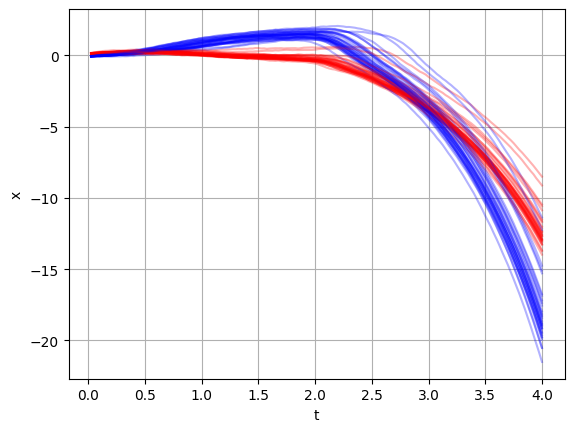

In [22]:
solver = Euler(forward_bridge, wiener_process)
path = solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=False, n_batches=32)
for i in range(32):
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()